In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from pathlib import PosixPath
from typing import Union, Tuple, List, Sequence
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, ToPILImage, Normalize
from torch import Tensor
import numpy as np
import multiprocessing as mp
import torch.nn.functional as F
import pandas as pd
from time import time
from tqdm import tqdm
import logging
from collections import OrderedDict
from matplotlib import pyplot as plt

In [3]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

## Importing custom modules

In [4]:
from super_image_resolution import get_root_path
from super_image_resolution.utils import (
    split, 
    make_dirs, 
    find_latest_model_version, 
    compute2d_means_and_stds, 
    load,
    dump,
    save_output)
from super_image_resolution.datasets import CustomDataset
from super_image_resolution.transforms import CustomResize, InvertNormalize
from super_image_resolution.models.unet import UNet

In [5]:
HPARAMS = pd.read_pickle("/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1/hparams")

In [6]:
HPARAMS

OrderedDict([('PROJECT_PATH',
              PosixPath('/home/mittal.nit/projects/super_image_resolution')),
             ('ASSETS_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets'),
             ('DATA_PATH', '/scratch/mittal.nit/faces-spring-2020'),
             ('MODEL_NAME', 'unet_l1loss_batchnorm'),
             ('MODEL_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm'),
             ('WEIGHTS_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/weights'),
             ('MODEL_WEIGHTS', 'model'),
             ('OPTIM_WEIGHTS', 'optim'),
             ('LR_SCH_WEIGHTS', 'lr_sch'),
             ('VERSION', 1),
             ('EXPERIMENT_VERSION_PATH',
              '/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/version_1'),
             ('LOG', 'log'),
             ('HPARAMS', 'hparams'),
             ('METRICS', 'metrics'),
    

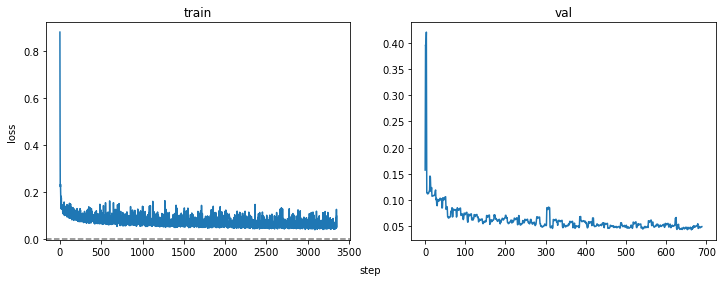

In [7]:
metrics = pd.read_pickle(os.path.join(HPARAMS["EXPERIMENT_VERSION_PATH"], HPARAMS["METRICS"]))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.plot(metrics["train"]["step"])
ax1.axhline(y=0, linestyle="dashed", color="gray")
ax1.set_title("train")
ax2.plot(metrics["val"]["step"])
# ax2.axhline(y=0, linestyle="dashed", color="gray")
ax2.set_title("val")
fig.text(x=.08, y=.5, s="loss", va="center", rotation=90)
fig.text(x=.5, y=.01, s="step", ha="center")
plt.show()

In [8]:
train, val, test = split(
    path=HPARAMS["DATA_PATH"], 
    ratios=HPARAMS["SPLIT_RATIOS"],
    seed=HPARAMS["RANDOM_SEED"])

in_transforms = Compose([
    CustomResize(size=64, interpolation=InterpolationMode.BICUBIC), 
    CustomResize(size=128, interpolation=InterpolationMode.BICUBIC), 
    ToTensor(), 
    Normalize(mean=HPARAMS["DATA_IN_NORM"]["means"], std=HPARAMS["DATA_IN_NORM"]["stds"])
])
    
out_transforms = Compose([
    Resize(size=128, interpolation=InterpolationMode.BICUBIC), 
    ToTensor(),
    Normalize(mean=HPARAMS["DATA_OUT_NORM"]["means"], std=HPARAMS["DATA_OUT_NORM"]["stds"])
])


train_dataset = CustomDataset(
    paths=train, in_transforms=in_transforms, out_transforms=out_transforms)

val_dataset = CustomDataset(
    paths=val, in_transforms=in_transforms, out_transforms=out_transforms)

test_dataset = CustomDataset(
    paths=test, in_transforms=in_transforms, out_transforms=out_transforms)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=HPARAMS["TRAIN_BATCH_SIZE"],
    shuffle=True, 
    num_workers=HPARAMS["NUM_WORKERS"])

val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=HPARAMS["VAL_BATCH_SIZE"],
    shuffle=False,
    num_workers=HPARAMS["NUM_WORKERS"])

test_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=HPARAMS["TEST_BATCH_SIZE"],
    shuffle=False, 
    num_workers=HPARAMS["NUM_WORKERS"])

In [9]:
in_invert_norm = InvertNormalize(
    num_channels=3,
    mean=torch.tensor(HPARAMS["DATA_IN_NORM"]["means"]),
    std=torch.tensor(HPARAMS["DATA_IN_NORM"]["stds"]))

out_invert_norm = InvertNormalize(
    num_channels=3,
    mean=torch.tensor(HPARAMS["DATA_OUT_NORM"]["means"]),
    std=torch.tensor(HPARAMS["DATA_OUT_NORM"]["stds"]))

## Loading trained model

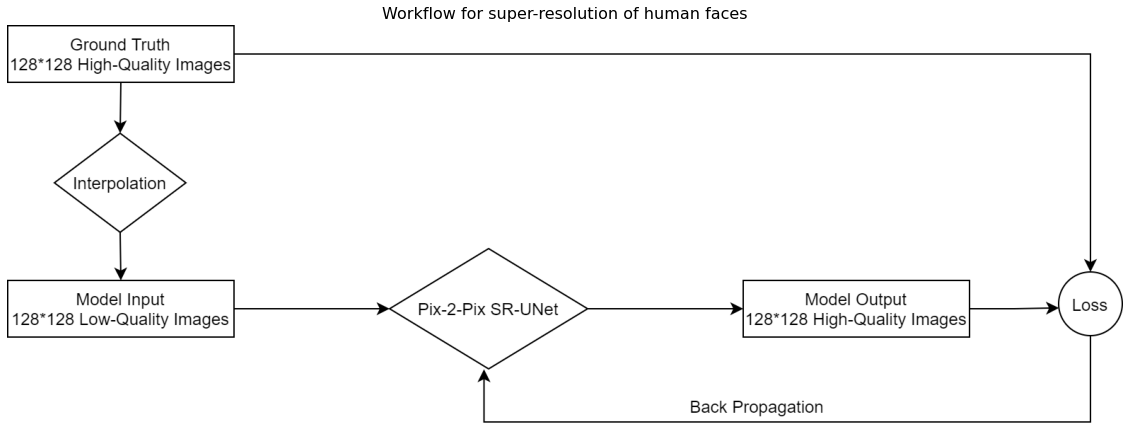

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(plt.imread('/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/SR-UNET Workflow.png'))
ax.set_title("Workflow for super-resolution of human faces", fontdict={"fontsize": 16})
ax.set_axis_off()
plt.show()

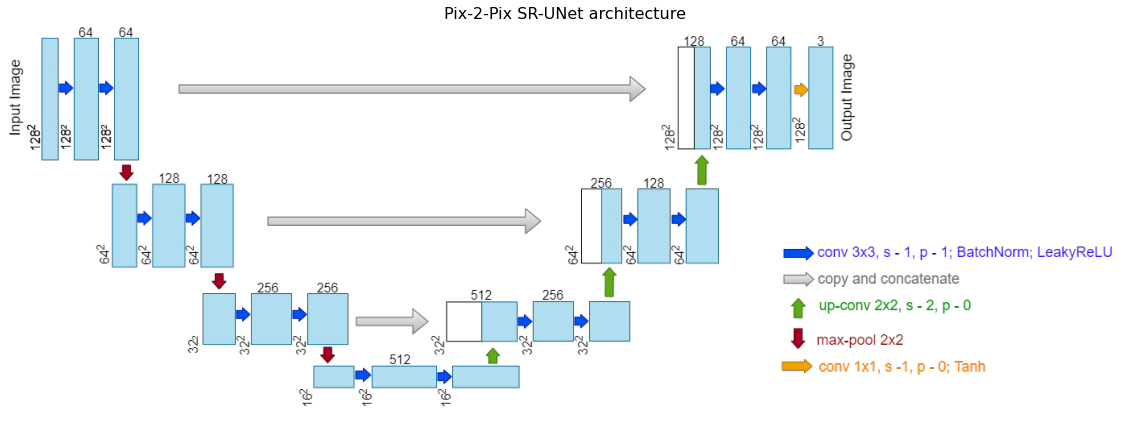

In [47]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(plt.imread('/home/mittal.nit/projects/super_image_resolution/assets/unet_l1loss_batchnorm/sr-unet.png'))
ax.set_title("Pix-2-Pix SR-UNet architecture", fontdict={"fontsize": 16})
ax.set_axis_off()
plt.show()

In [10]:
model = UNet(
    in_channels=HPARAMS["IN_CHANNELS"], 
    out_channels=HPARAMS["OUT_CHANNELS"],
    norm=HPARAMS["NORM"],
    act=HPARAMS["ACTIVATION"])
model.to(HPARAMS["DEVICE"])

UNet(
  (encoder): UNetEncoder(
    (downs): ModuleList(
      (0): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): DoubleConv2d(
        (down): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

## Loading pre-trained model if exits (using val loss to save best model)

In [11]:
if True and HPARAMS["MODEL_WEIGHTS"] in os.listdir(HPARAMS["WEIGHTS_PATH"]):
    try:
        model.load_state_dict(torch.load(os.path.join(HPARAMS["WEIGHTS_PATH"], HPARAMS["MODEL_WEIGHTS"])))
        print("Loaded pre-trained model weights")
    except Exception as e:
        print(f"Error: {e}")

Loaded pre-trained model weights


In [12]:
def validation_step(model, X: Tensor, Y: Tensor) -> Tuple[float, Tensor]:
    torch.set_grad_enabled(False)
    model.eval()
    Y_hat = HPARAMS["SCALE_Y"] * model(X)
    return Y_hat

In [13]:
X, Y = next(iter(val_loader))
X, Y = X.to(HPARAMS["DEVICE"]), Y.to(HPARAMS["DEVICE"])
Y_hat = validation_step(model, X, Y)

X = in_invert_norm(X.to("cpu"))
Y = out_invert_norm(Y.to("cpu"))
Y_hat = out_invert_norm(Y_hat.to("cpu"))

In [14]:
def display_random_output(X: List[Tensor], Y: List[Tensor], Y_hat: List[Tensor]):
    idxs = np.arange(len(X))
    np.random.shuffle(idxs)
    i = np.random.choice(idxs)
    
    x = X[i].numpy().transpose(1,2,0)
    y = Y[i].numpy().transpose(1,2,0)
    y_hat = Y_hat[i].numpy().transpose(1,2,0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    
    ax1.imshow(x)
    ax1.set_axis_off()
    ax1.set_title("low-resolution input")
    
    ax2.imshow(y)
    ax2.set_axis_off()
    ax2.set_title("high-resolution ground truth")
    
    ax3.imshow(y_hat)
    ax3.set_axis_off()
    ax3.set_title("high-resolution output")
    plt.show()

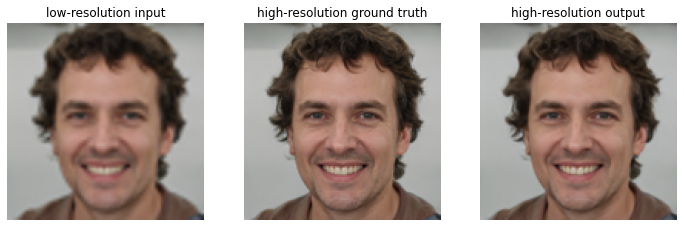

In [15]:
display_random_output(X,Y,Y_hat)

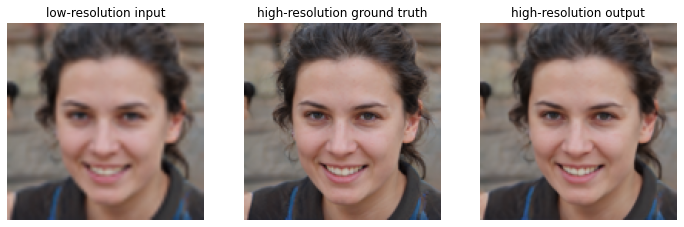

In [16]:
display_random_output(X,Y,Y_hat)

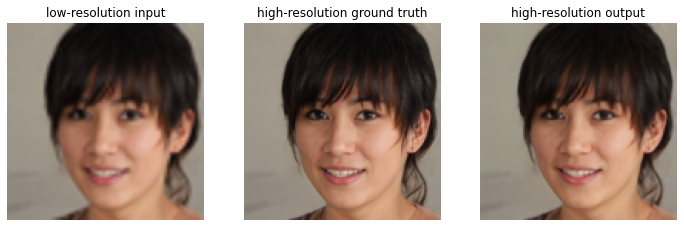

In [17]:
display_random_output(X,Y,Y_hat)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


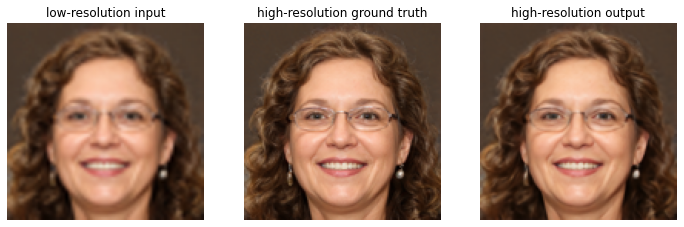

In [18]:
display_random_output(X,Y,Y_hat)

In [19]:
def compute_ssim(X, Y, Y_hat):
    """Compute structural simmilarity index."""
    ssim_in, ssim_out = [], []
    for i in tqdm(range(len(X)), leave=False):
        ssim_in.append(ssim(X[i].numpy().transpose(1,2,0), Y[i].numpy().transpose(1,2,0), multichannel=True))
        ssim_out.append(ssim(Y_hat[i].numpy().transpose(1,2,0), Y[i].numpy().transpose(1,2,0), multichannel=True))
    return ssim_in, ssim_out

In [20]:
ssim_in, ssim_out= compute_ssim(X, Y, Y_hat)
np.mean(ssim_in), np.mean(ssim_out)

(0.9606022972027738, 0.9855282937519318)

In [21]:
def compute_psnr(X, Y, Y_hat):
    """Compute structural simmilarity index."""
    psnr_in, psnr_out = [], []
    for i in tqdm(range(len(X)), leave=False):
        psnr_in.append(psnr(Y[i].numpy().transpose(1,2,0), X[i].numpy().transpose(1,2,0)))
        psnr_out.append(psnr(Y[i].numpy().transpose(1,2,0), Y_hat[i].numpy().transpose(1,2,0)))
    return psnr_in, psnr_out

In [22]:
psnr_in, psnr_out= compute_psnr(X, Y, Y_hat)
np.mean(psnr_in), np.mean(psnr_out)

(31.825441574014235, 36.68971195105394)